# Bias and Fairness

[Amazon scraps secret AI recruiting tool that showed bias against women](https://www.reuters.com/article/idUSKCN1MK0AG/)

[Google’s Photo App Still Can’t Find Gorillas. And Neither Can Apple’s.](https://www.nytimes.com/2023/05/22/technology/ai-photo-labels-google-apple.html)

[Twitter taught Microsoft’s AI chatbot to be a racist asshole in less than a day](https://www.theverge.com/2016/3/24/11297050/tay-microsoft-chatbot-racist)

[Predictive Policing Algorithms Are Racist. They Need to Be Dismantled.](https://www.technologyreview.com/2020/07/17/1005396/predictive-policing-algorithms-racist-dismantled-machine-learning-bias-criminal-justice/)

[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)

[Does Object Recognition Work for Everyone?](https://openaccess.thecvf.com/content_CVPRW_2019/papers/cv4gc/de_Vries_Does_Object_Recognition_Work_for_Everyone_CVPRW_2019_paper.pdf)

## Class Imbalance

The dataset set that we have does not reflect the real world distribution of the classes. Let's consider a simple example to illustrate the problem, and some possible solutions.

Let's first consider a synthetic dataset with imbalanced classes:

- Group A is gaussian distributed with mean -1 and standard deviation 1.
- Group B is gaussian distributed with mean 1 and standard deviation 1.



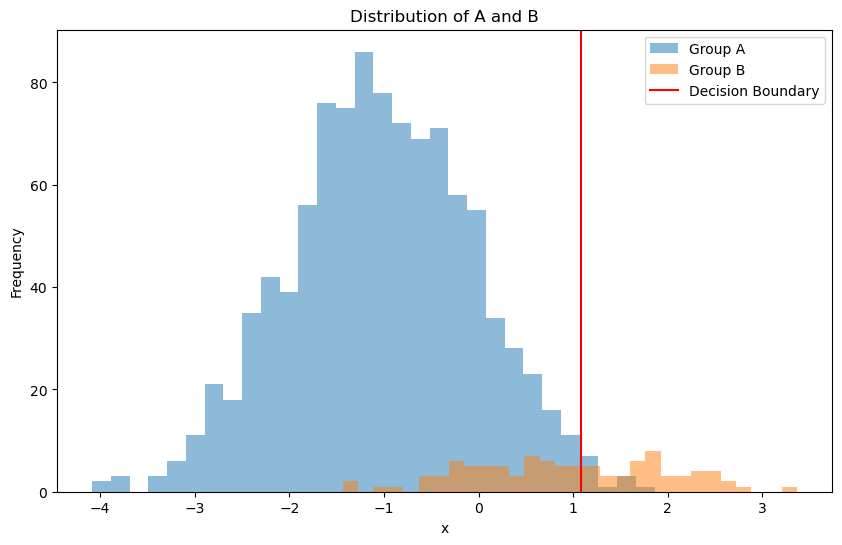

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


# Generating data for a 1D Gaussian Mixture
np.random.seed(7)
std = 1
n_A = 1000
n_B = 100
group_A = np.random.normal(-1, std, n_A)  # Group A: mean = -1
group_B = np.random.normal(1, std, n_B)    # Group B: mean = 1

# Labels for the groups
labels_A = np.full(n_A, "A")
labels_B = np.full(n_B, "B")

# Combining the data
data = np.concatenate([group_A, group_B])
labels = np.concatenate([labels_A, labels_B])

# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution of A and B')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()

# Applying Logistic Regression
X = data.reshape(-1, 1)
y = labels
model = LogisticRegression()
model.fit(X, y)

# Calculate the decision boundary: intercept + coef*x = 0
decision_boundary = -model.intercept_ / model.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary, color='red', label='Decision Boundary')
plt.legend()

# Show the plot
plt.show()

Because of the imbalance, the classifier works well on group A but poorly on group B.

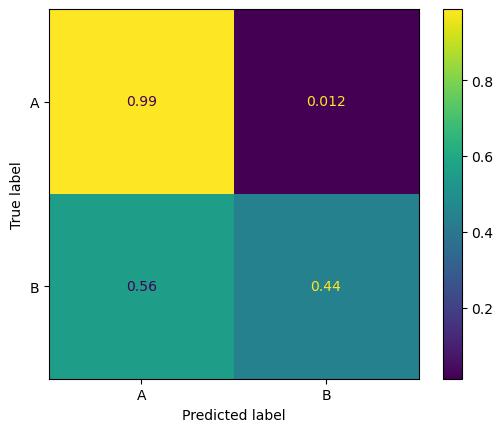

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predicting the labels
pred_labels = model.predict(X)


# Confusion matrix for group B
conf_matrix_B = confusion_matrix(labels, pred_labels, normalize='true')

disp_B = ConfusionMatrixDisplay(conf_matrix_B, display_labels=['A', 'B'])
disp_B.plot()


One way to address this issue is to use a balanced dataset. We can do this by resampling the minority class (group B) to have the same number of samples as the majority class (group A).

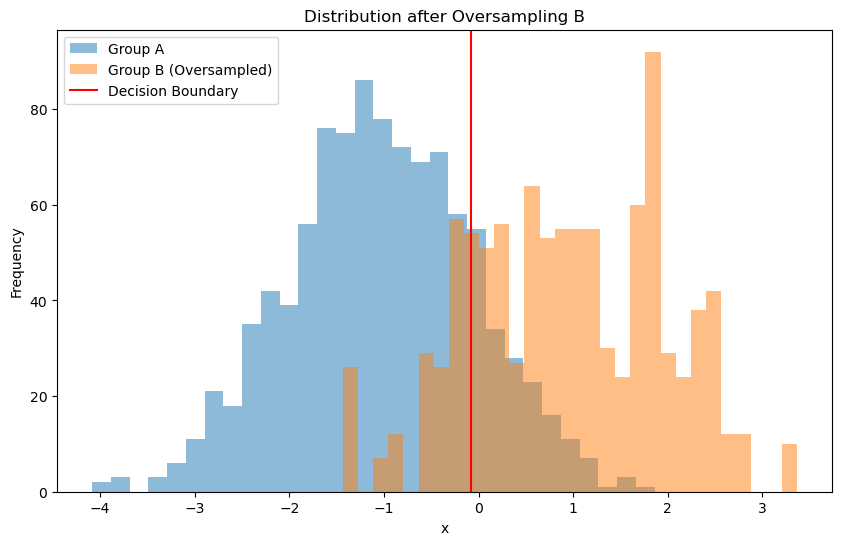

In [35]:
from sklearn.utils import resample

# Resampling the data to mitigate bias
# Oversampling Group B
group_B_resampled = resample(group_B,
                               replace=True,
                               n_samples=len(group_A),  # match the number of samples in Group A
                               random_state=0)

labels_B_resampled = np.full(len(group_B_resampled), "B")

# Combining the oversampled data
data_resampled = np.concatenate([group_A, group_B_resampled])
labels_resampled = np.concatenate([labels_A, labels_B_resampled])

# Visualizing the oversampled data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B_resampled, bins=30, alpha=0.5, label='Group B (Oversampled)')
plt.title('Distribution after Oversampling B')
plt.xlabel('x')
plt.ylabel('Frequency')


# Retraining logistic regression with the resampled data
X_resampled = data_resampled.reshape(-1, 1)
y_resampled = labels_resampled
model_resampled = LogisticRegression()
model_resampled.fit(X_resampled, y_resampled)

decision_boundary = -model_resampled.intercept_ / model_resampled.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary, color='red', label='Decision Boundary')
plt.legend()
plt.show()




Another way is to reweight the data. 

In our loss function, 


$$
\text{total loss} = \sum_{i=1}^{n}  \text{error}(y_i, \hat{y}_i)
$$

where $\text{error}(y_i, \hat{y}_i)$ is the error function, and $y_i$ is the true label, and $\hat{y}_i$ is the predicted label.

We are actually weighting each data point equally.

If we have a class imbalance, we can reweight the data points.

$$
\text{total loss} = \sum_{i=1}^{n}  w_i \cdot \text{error}(y_i, \hat{y}_i)
$$

where $\text{weight}(y_i)$ is the weight for the data point $i$.



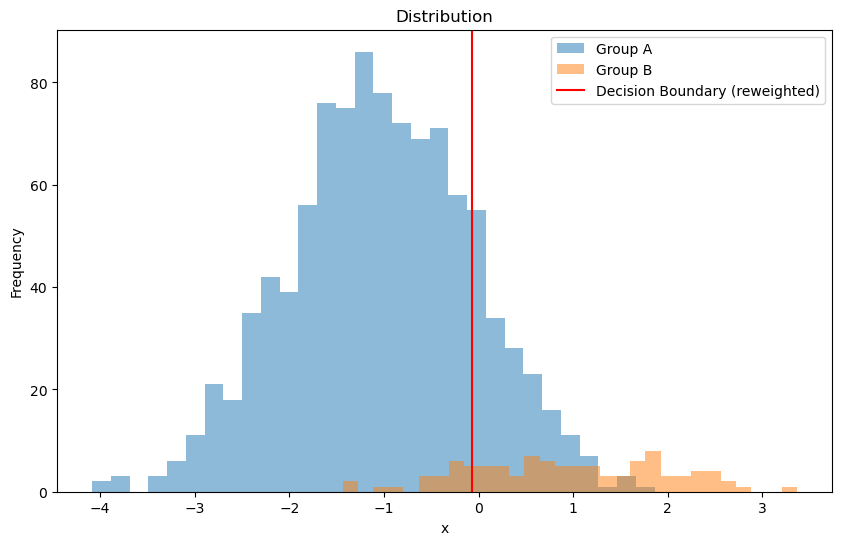

In [36]:
# Assign weights to mitigate bias
weight_A = n_B / (n_A + n_B) # there is more of A, so we want to weight it less
weight_B = n_A / (n_A + n_B) # there is less of B, so we want to weight it more

# The weights are assigned based on the labels chosen such that
#  number of A * weight_A = number of B * weight_B
# roughly speaking, total errors from A and B are balanced

# weights is an array of weights for each sample
# if the label is A, the weight is weight_A, otherwise it is weight_B
weights = np.where(labels == "A", weight_A, weight_B)

# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution')
plt.xlabel('x')
plt.ylabel('Frequency')

# Training logistic regression with custom weights
X = data.reshape(-1, 1)
y = labels
model_weighted = LogisticRegression()
model_weighted.fit(X, y, sample_weight=weights)

# Calculate the decision boundary for the weighted model
decision_boundary_weighted = -model_weighted.intercept_ / model_weighted.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary_weighted, color='red', label='Decision Boundary (reweighted)')
plt.legend()
plt.show()


## Fair Classification

*This section is based on [this video](https://www.youtube.com/watch?v=c2_ezuAnCrA&t=333s).*

**Protected Attributes**: Features such as sex, race, and age are considered "protected attributes." It's crucial to ensure that classifiers remain fair concerning these attributes.

## What is Fairness?

Imagine developing a classifier to determine eligibility for loans or job interviews. 
In these scenarios, a "positive" classification endows a benefit, such as a loan or job offer, and 
the "true labels" might represent "merit" or "qualification." 
We aim to match qualified individuals with appropriate benefit. 
The confusion matrix in this context has the following interpretation:

- **True Positive (TP)**: Qualified individuals who receive the benefit.
- **False Positive (FP)**: Unqualified individuals who receive the benefit.
- **True Negative (TN)**: Unqualified individuals who do not receive the benefit.
- **False Negative (FN)**: Qualified individuals who do not receive the benefit.

### Criteria for Fairness

Some example fairness criteria include:

- **Equal Opportunity**: The True Positive Rate (TPR) should be similar across all groups.
- **Equalized Odds**: Both the True Positive Rate and the False Positive Rate should be consistent across groups.
- **Demographic Parity**: The likelihood of receiving a benefit should be equal across all demographic groups.


## Why Not Ignore Protected Attributes?

Ignoring protected attributes, a strategy known as "fairness through unawareness," often falls short due to several reasons:

- **Correlation**: Protected attributes may correlate with other features, inadvertently influencing the classifier.
- **Relevance**: Attributes like sex and age are critical in contexts such as healthcare.
- **Regulatory Compliance**: Certain laws and guidelines may require adherence to specific fairness standards.


In our previous example of class imbalance, we can also post-process the decision boundary to make it "fair".

Here is an criteria of fairness: the true positive rate should be the same for both groups. Therefore, we can search for different decision boundaries that satisfy this criteria.

Here is an algorithm:

- Iterate over a range of thresholds.
- For each threshold, calculate the true positive rate (TPR) for each group.
- Compute the difference between the TPRs.
- Choose the threshold with the smallest difference between the TPRs.

Optimal Threshold: 0.08080808080808081, Difference in TPR 0.021999999999999992


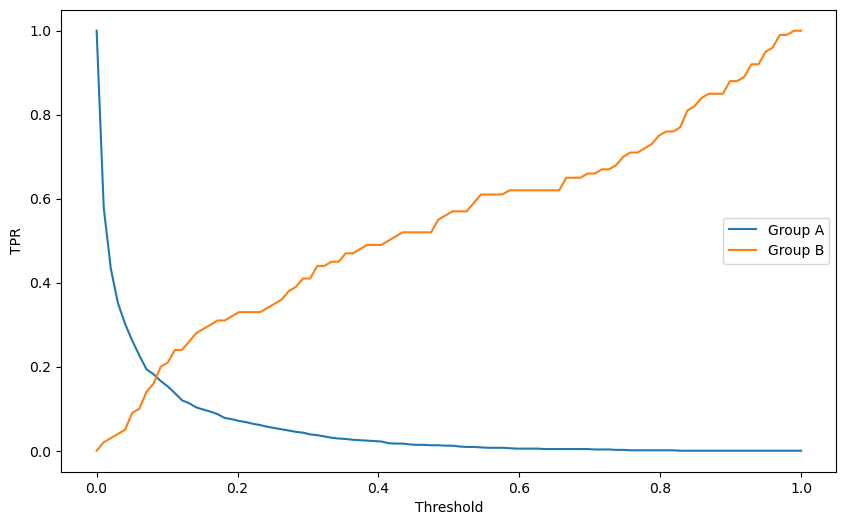

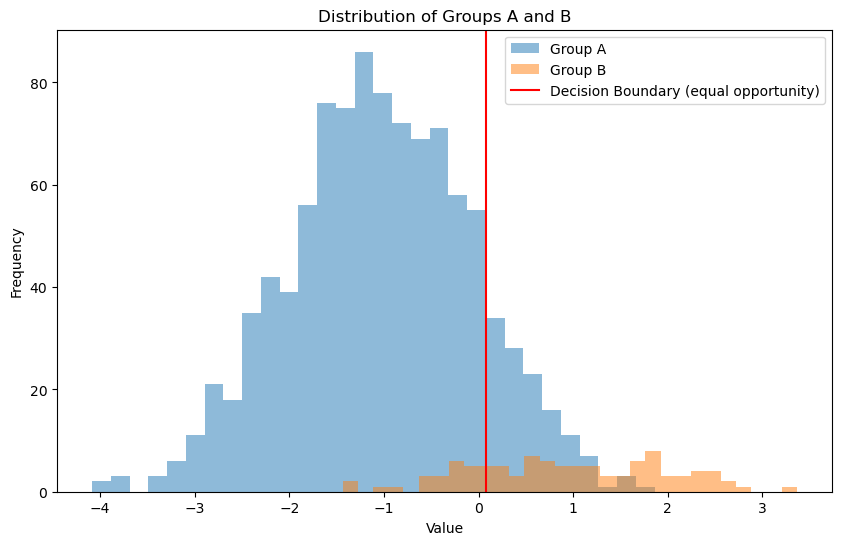

In [40]:
# mask for samples in group A and B
mask_group_A = labels == "A"
mask_group_B = labels == "B"

# This is the predicted probability of being in group A for each sample
probabilities = model.predict_proba(X)[:, 1]

# We will try different thresholds to find the one that minimizes the difference in TPRs
thresholds = np.linspace(0, 1, 100)

# we initialize the best difference in TPRs to infinity and the best threshold to None
best_diff = float('inf')
best_threshold = None

list_tpr_A = []
list_tpr_B = []

for threshold in thresholds:
    
    # Assigning group labels based on the threshold
    # probabilities[mask_group_A] the predicted probabilities for group A
    # group_A_pred is a N-by-1 boolean array, where N is the number of samples in group A
    # group_A_pred[i] is True if the predicted probability for sample i in group A is greater than the threshold, and therefore the sample is predicted to be in group B
    group_A_pred = probabilities[mask_group_A] > threshold
    group_B_pred = probabilities[mask_group_B] < threshold

    # group_A_pred is an array of "is the i-th sample in group A predicted to be in group A?"
    # therefore the average of this array is the True Positive Rate (TPR) for group A
    # similarly for group B
    tpr_A = np.mean(group_A_pred)
    tpr_B = np.mean(group_B_pred)

    list_tpr_A.append(tpr_A)
    list_tpr_B.append(tpr_B)
    
    # Measure the absolute difference between TPRs
    diff = abs(tpr_A - tpr_B)
    if diff < best_diff:
        best_diff = diff
        best_threshold = threshold

# Finding and printing optimal thresholds
print(f"Optimal Threshold: {best_threshold}, Difference in TPR {best_diff}")


# plot the TPRs as a function of the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, list_tpr_A, label='Group A')
plt.plot(thresholds, list_tpr_B, label='Group B')
plt.xlabel('Threshold')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution of Groups A and B')
plt.xlabel('Value')
plt.ylabel('Frequency')
# Plotting the decision boundary
plt.axvline(x=best_threshold, color='red', label='Decision Boundary (equal opportunity)')
plt.legend()
plt.show()

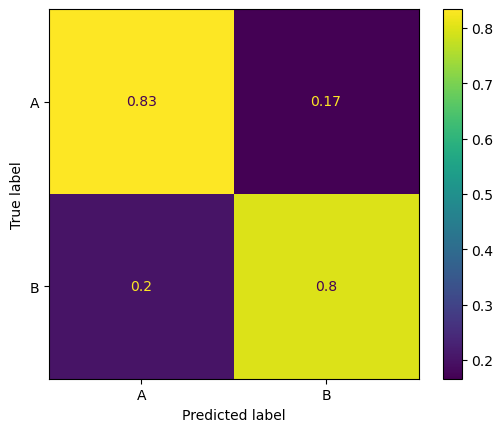

In [ ]:
# Predicting the labels
pred_group_A = probabilities > best_threshold

pred_labels = np.where(pred_group_A, "B", "A")

# Confusion matrix for group B
conf_matrix_B = confusion_matrix(labels, pred_labels, normalize='true')

disp_B = ConfusionMatrixDisplay(conf_matrix_B, display_labels=['A', 'B'])
disp_B.plot()
